In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import math

In [2]:
def imshow(im):
    width, height, *channels = im.shape
    if channels:
        plt.imshow(im[:,:,::-1])
    else:
        plt.imshow(im, cmap='gray')
    plt.axis('off')

In [3]:
def show(im, sh):
    if sh:
        imshow(im)
    

def make_gray(im, sh=False):
    result = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    show(result, sh)
    return result

def make_clahe(grayim, clipLimit, tileGridSize, sh=False):
    grayim = grayim.copy()
    clahe = cv2.createCLAHE(clipLimit=clipLimit, tileGridSize=tileGridSize)
    res = clahe.apply(grayim)
    show(res, sh)
    return grayim

def make_blur(im, size, eps, sh=False):
    res = cv2.GaussianBlur(im,size,eps)
    show(res, sh)
    return res

def make_median(im, size, sh=False):
    res =cv2.medianBlur(im,size)
    show(res, sh) 
    return res

def make_thresh(im, size, c, sh=False):
    # ret2, otsuim = cv2.threshold(im,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    thresh = cv2.adaptiveThreshold(im, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, size, c)
    show(thresh, sh)
    return thresh

def make_morph(im, size, sh=False):
    # k1 = np.ones((2, 2), np.uint8)
    k2 = np.ones(size, np.uint8)
    # im = cv2.dilate(im, k1, iterations=1)
    res = cv2.erode(im, k2, iterations=1)
    show(res, sh)
    return res

def make_canny(im, sh=False):
    res = cv2.Canny(im, 125, 255)
    show(res, sh)
    return res

def draw_hough(im, lines):
    img = im.copy()
    for r_theta in lines:
        arr = np.array(r_theta[0], dtype=np.float64)
        r, theta = arr
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*r
        y0 = b*r
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))
        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*(a))
        cv2.line(img, (x1, y1), (x2, y2), (0, 0, 255), 2)
    return img

def draw_contours(im, cnts):
    im = im.copy()
    cv2.drawContours(im, cnts, -1, (0,255,0), 3)
    return im

def make_contours(im, sh=False):
    contours, hierarchy = cv2.findContours(im, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    papercontour = contours[0]
    for con in contours:
        if cv2.contourArea(con) > cv2.contourArea(papercontour): # paper border is the largest contour
            papercontour = con

    contours = list(contours)
    contours.sort(key=lambda cnt: -cv2.contourArea(cnt))

    hulls = [cv2.convexHull(cnt) for cnt in contours]
    hulls.sort(key=lambda cnt: -cv2.contourArea(cnt))
    show(draw_contours(im, hulls), sh)
    return hulls

def make_corners(cnt):
    epsilon = 0.03 * cv2.arcLength(cnt, True)
    corners = cv2.approxPolyDP(cnt, epsilon, True)[::, 0, ::]
    return corners
    
def sort_corners(cnrs):
    sorted_points = sorted(cnrs, key=lambda x : x[0])

    left_points = sorted_points[0:2]
    top_left = left_points[0] if left_points[0][1] < left_points[1][1] else left_points[1]
    btm_left = left_points[0] if left_points[0][1] > left_points[1][1] else left_points[1]

    right_points = sorted_points[2:4]
    top_right = right_points[0] if right_points[0][1] < right_points[1][1] else right_points[1]
    btm_right = right_points[0] if right_points[0][1] > right_points[1][1] else right_points[1]

    return np.array([[top_left], [top_right], [btm_left], [btm_right]], dtype=np.float32)

def make_prespective(im, srcp, width, height, sh=False):
    dx, dy = 0, 0
    dstp = np.array([[[0+dx, 0+dy]], [[width-dx, 0+dy]], [[0+dx, height-dy]], [[width-dx, height-dy]]], dtype=np.float32)
    mat = cv2.getPerspectiveTransform(srcp, dstp)
    res = cv2.warpPerspective(im, mat, (width, height))
    show(res, sh)
    return res



In [4]:
cards = []
for path in os.listdir('cards'):
    cards.append('cards/' + path)


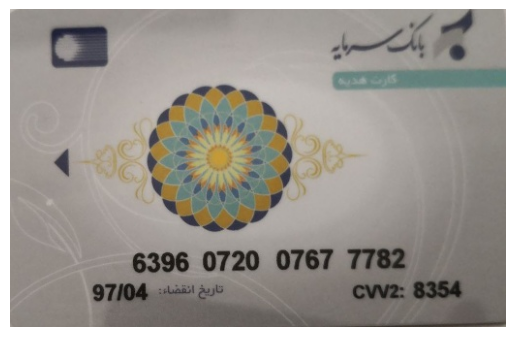

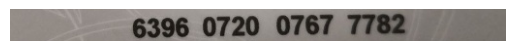

In [8]:
cutnum_config = {
                'clahe':{'limit':2.0, 'size':(8,8)},
                'blur':{'size':(5,5), 'eps':5},
                'median':5,
                'thresh':{'size':15, 'c':15},
                'morph': (3,3),
                'outsize':(512,328)}

def cut_number(im, config):
    original = im.copy()
    im = make_gray(im, False)
    im = make_blur(im, config['blur']['size'], config['blur']['eps'], False)
    im = make_thresh(im, config['thresh']['size'], config['thresh']['c'], False)
    im = make_morph(im, config['morph'], False)

    im = 255 - im[10:im.shape[0]-10, 10: im.shape[1]-10]
    maxrow = np.argmax(im.mean(1))
    x1, x2 = maxrow, maxrow
    while im[x1-1:x1+2].mean() >im[maxrow].mean()/3 and x1 != 0:
        x1 -= 1
        
    while im[x2-1:x2+2].mean() >im[maxrow].mean()/3 and x2 != im.shape[0]-1:
        x2 += 1
    
    return original[x1+5:x2+15]



im = cv2.imread('cutpics/cr_6.jpg')
im = cv2.resize(im, (512, 328))
imshow(im)
plt.show()
num = cut_number(im, cutnum_config)
imshow(num)
plt.show()